# A Linear Regression Analysis of PBSB Artwork Data
This analysis uses linear regression to answer the following question: Can we estimate how long a portrait will take to complete?

Data wrangling performed in the basic and advanced analysis is repeated here with minimal explanation. Some additional pre-processing of the input data was done in Excel. This dataset uses data at the order line level of detail which gives better visibility into individual pieces of art.

## Import libraries

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import squarify

# Machine learning and regression libraries
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score



## Import Excel file

In [21]:
# Define the URL of the dataset - in this case we are using a dataset that has been uploaded to OneDrive and shared
#file_path = 'C:\\Users\\simon\\OneDrive\\Documents\\Data Analysis\\Art\\Artwork-Items.xlsx'

# Load the dataset into a DataFrame
df = pd.read_excel('Data/Artwork-Items-Reg.xlsx')

# Display the first few rows to ensure it loaded correctly
df.head()

,CustomerID,PortraitID,ServiceType,PortraitSubject,NumSubjects,Medium,SaleDate,Size,Frame,CompletedDate,ActualTime,Price,PromisedBy
0,8,10,Commission,People,1.0,Graphite,2003-04-01,11x14,NaN,2003-04-15,16,0.0,2003-04-15
1,6,12,Commission,House/dwelling,1.0,Pen & Ink / Watercolor,2003-04-01,11x14,NaN,NaT,5,0.0,NaT
2,26,62,Commission,Dog,1.0,Acrylic,2003-10-06,11x14,NaN,2003-11-09,4,0.0,2003-11-30
3,68,116,Commission,Dog,1.0,Pastel,2004-10-10,16x20,NaN,NaT,0,0.0,NaT
4,86,137,Commission,Dog,1.0,Oil,2005-06-08,24x30,NaN,NaT,0,0.0,2005-09-30


## Basic Data Cleanup
Unlike the price data used in previous analyses, the item price data is already formatted as a number and doesn't need further manipulation. There are still some rows with missing values which must be removed.

In [22]:
# Drop the rows with no order date and no sale type
df = df.dropna(subset=['SaleDate'])


In [23]:
# Filter out rows with 'Price' == 0 or 'ActualTime' == 0
df = df[(df['Price'] > 100)]
df = df[(df['ActualTime'] > 0)]

In [24]:
# Filter out any records which dont have 'ServiceType' == 'Commission' or 'ServiceType' == 'Artwork sale'
df = df[(df['ServiceType'] == 'Commission') | (df['ServiceType'] == 'Artwork sale')] 

In [25]:
df.head()

,CustomerID,PortraitID,ServiceType,PortraitSubject,NumSubjects,Medium,SaleDate,Size,Frame,CompletedDate,ActualTime,Price,PromisedBy
114,311,624,Artwork sale,NaN,0.0,NaN,2019-11-10 00:00:00,6x12,Framed,2019-03-31,8,113.53,NaT
116,208,304,Artwork sale,Landscape,0.0,Oil,2011-10-02 15:15:15,18x28,NaN,2010-08-31,20,120.00,NaT
117,215,370,Artwork sale,Landscape,0.0,Oil,2014-05-25 15:44:54,6x8,NaN,2014-03-30,2,120.00,NaT
118,21,68,Commission,Person,1.0,Color Pencil,2003-11-15 00:00:00,8x10,NaN,2003-12-07,8,125.00,2003-12-15
120,254,383,Artwork sale,Landscape,0.0,Oil,2014-06-22 09:16:00,10x8,NaN,2014-06-15,4,125.00,NaT


## Data Transformation

The source data has been cleaned up since previous analyses and obvious outliers were corrected.

### Extract 'Year'
Since the SaleDate column is already in date/time format, the Year can be extracted directly.

In [26]:
# Create a Year column
df['Year'] = df['SaleDate'].dt.year.astype(int)

### Calculate 'Area' for each item where possible
Use data in the 'Size' column to calculate the area of each painting in square incheas.

In [27]:
# Function to calculate area from 'Size' column
def calculate_area(size):
    if pd.isna(size):
        return None  
    try:
        # Convert the value to a string
        size_str = str(size)
        # Use regular expression to find the first pair of numbers (including decimals)
        match = re.search(r'(\d+(\.\d+)?)\s*[xX*]\s*(\d+(\.\d+)?)', size_str)
        if match:
            height, width = map(float, match.groups()[::2])  # Extract only the numeric parts
            return height * width
        else:
            return None  # Handle cases where the size format is incorrect
    except ValueError:
        return None  # Handle cases where the size format is incorrect

# Apply the function to the 'Size' column and create a new 'Area' column
df['Area'] = df['Size'].apply(calculate_area)

# Display the DataFrame with the new 'Area' column
print(df['Area'].head())



114     72.0
116    504.0
117     48.0
118     80.0
120     80.0
Name: Area, dtype: float64


### Remove Records With 'Area' == null

In [28]:
# Drop any records that don't have a useable 'Area'
df = df.dropna(subset=['Area'])

### Create a Price Per Hour Feature and a Price Per Area Feature

In [29]:
df['Price_Per_Hour'] = df['Price']/df['ActualTime']
df['Price_Per_Area'] = df['Price']/df['Area']

### Separate Out Commissioned Portraits
Create a dataframe that only contains commissioned paintings.

In [30]:
df_commission = df[df['ServiceType'] == 'Commission']
df_retail = df[df['ServiceType'] == 'Artwork sale']

### Drop Commission Records with Missing Dates

In [31]:
# drop any commission records with missing dates
df_commission = df_commission.dropna(subset=['CompletedDate'])

### Filter Out Mediums Other Than Oil and Pastel
The choice of medium has an impact on pricing and time taken to complete. We're just interested in oil and pastel portraits for this analysis as they make up the bulk of the studio output.

In [32]:
# Filter out values that don't start with 'Oil' or 'Pastel'
df_commission = df_commission[df_commission['Medium'].str.match(r'^(Oil|Pastel)', na=False)]

### Remove Commission Records With no Subjects

In [33]:
df_commission = df[df['NumSubjects'] > 0]

## Linear Multi Regression

### Can We Predict Time to Complete?
I'm interested in being able to estimate how long a portrait will take to complete. I could use that to help price it correctly and to figure out my studio workload with more accuracy.

I have tracked the amount of time it takes to complete a portrait ever since I first started painting full-time, although I suspect that the data is really more of an estimate than an accurate reflection of reality.

Portraits of people are the most time-consuming and difficult to complete, so we'll focus on those for now.

In [34]:
# Filter all portraits out of the dataframe except for those of people
df_people = df_commission[(df_commission['PortraitSubject'] == 'Person') | (df_commission['PortraitSubject'] == 'People')]

df_people.shape

(20, 17)

Before we start regression, let's quickly plot the relationship between ActualTime and Year to confirm my suspicion that there's no direct relationship between the two..

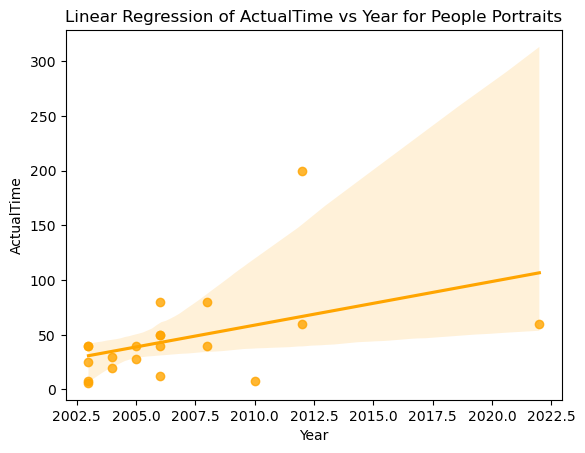

In [35]:
sns.regplot(
    x='Year',
    y='ActualTime',
    data=df_people,
    color = 'orange'
)
plt.title('Linear Regression of ActualTime vs Year for People Portraits')

# Save the plot as a PNG file
plt.savefig('Graphics/actual_time_vs_year.png', format='png', dpi=300)

plt.show()

This plot indicates there might be a direct correlation between ActualTime and Year, but I want to see if there is more meaningful relationship if we inspect the data more carefully:  I know that the time spent increases with number of subjects and with area, so lets find a way to show the trends in those over time by looking at:

1. ActualTime per Area vs. Year
2. ActualTime per Head vs. Year

In [40]:
# Calculate time per unit area. We already know that there are no zeros remaining in the Area column.
df_people.loc[:,'Time_Per_Area'] = df_people['ActualTime']/df_people['Area']

# Calculate time per subject. We already know that there are no zeros remaining in the NumSubjects column.
df_people.loc[:,'Time_Per_Head'] = df_people['ActualTime']/df_people['NumSubjects']

Before we start a more complex regression, let's plot the relationships between the variables.

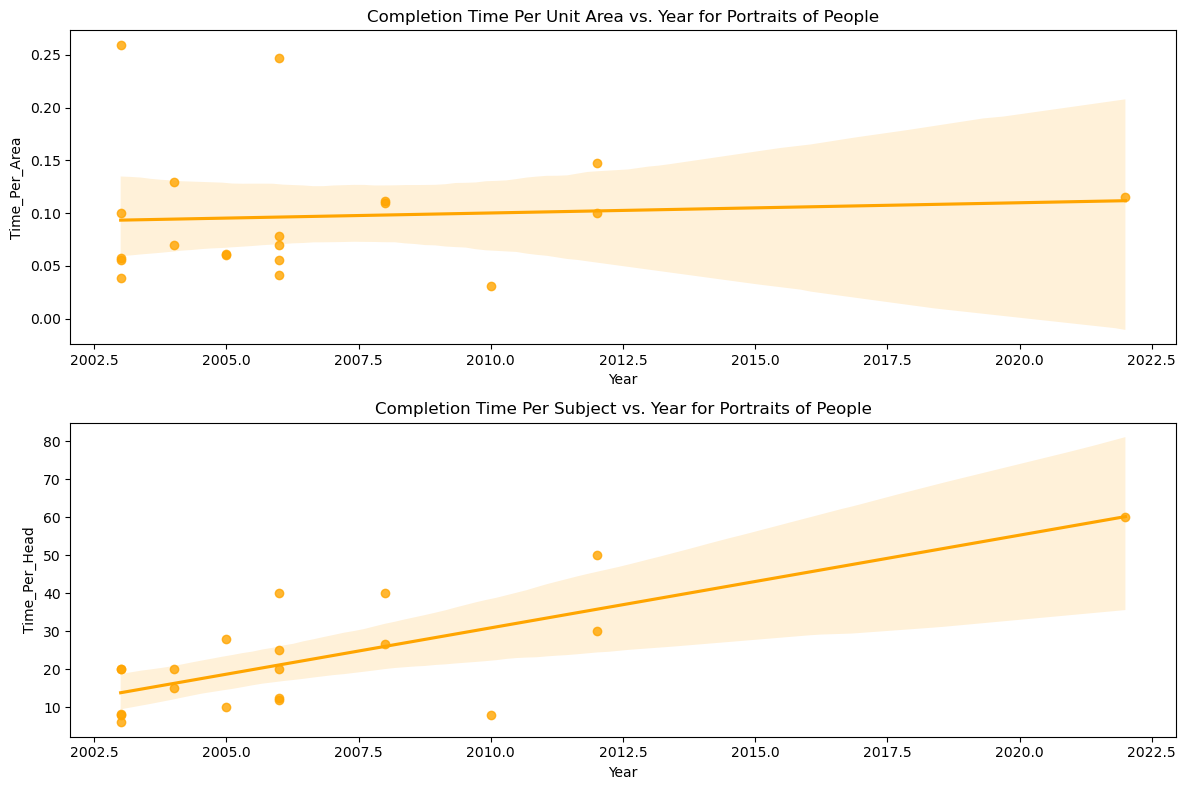

In [37]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

sns.regplot(
    x='Year',
    y='Time_Per_Area',
    data=df_people,
    color = 'orange',
    ax=axs[0]
)
axs[0].set_title('Completion Time Per Unit Area vs. Year for Portraits of People')

sns.regplot(
    x='Year',
    y='Time_Per_Head',
    data=df_people,
    color = 'orange',
    ax=axs[1]
)
axs[1].set_title('Completion Time Per Subject vs. Year for Portraits of People')

plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('Graphics/time_per_head_and_area_vs_year.png', format='png', dpi=300)

plt.show()

There are several outliers in the data, and I suspect that there may be some misclassification of the data that warrants further inspection.

However, there is an aspect of the portrait creation process that this regression analysis misses completely: some painting projects simply take longer than others and it can be difficult to predict which ones those will be in advance.

In [38]:
#Fit linear regression to predict price using list of features
x2=df_people[['Year', 'Area', 'NumSubjects']]
y2=df_people['ActualTime']
lre_multi=LinearRegression()
lre_multi.fit(x2, y2)
print('The R2 value is: ', lre_multi.score(x2,y2))

# Get the intercept
intercept = lre_multi.intercept_
print(f"The intercept is: {intercept}")

# Get the coefficients
coefficients = lre_multi.coef_

# Display the coefficients
for feature, coef in zip(x2.columns, coefficients):
    print(f"The coefficient for {feature} is {coef}")

The R2 value is:  0.6059059359108192
The intercept is: -5714.259688343059
The coefficient for Year is 2.846720892057734
The coefficient for Area is 0.05614672115382439
The coefficient for NumSubjects is 9.431313897337578


We end up with a reasonably good fit for the regression. Let's check the model by estimating how long it would take to complete a portrait of 1 person on a 20x26 canvas in 2025.

In [39]:
# Put data into variables
year = 2025
area = 20 * 26
num_subjects = 1

# Predict price
time = intercept + coefficients[0] * year + coefficients[1] * area + coefficients[2] * num_subjects

print('The predicted time is: ', time.round(1), 'hours')

The predicted time is:  89.0 hours


That seems like a very good estimate.